# XLM Classification example
This notebook is an example of training the XLM model for binary classification, with a max. sequence length of 256 for one epoch.  I use no evaluation during training as it slows the training down, if used, a val.tsv needs to be defined in the data/ directory, and the same preprocessing needs to be applied as for evaluation data (create_features and create_dataloader functions). 

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define dictionary containing all model and environmental parameters

In [3]:
task_name  = 'xlm_256' 
params = {
    'data_dir': 'data/',                              # Directory of train.tsv, evaluation.tsv and test.tsv (optional)
    'params_dict_dir' : f'{task_name}_params.json',   # We save the dict here. It will be overwritten with more info. 
    'model_type':  'xlm',                             # Defines the model type
    'model': 'xlm-mlm-ende-1024',                     # Defines the exact model
    'task_name': 'binary',
    'output_dir': f'outputs/{task_name}/',            # The output will be saved in the output/bert_128 directory
    'cache_dir': 'cache/',                            
    'do_train': True,                                 # Need to specify True for training
    'do_eval': False,                                 # Need to specify True for evaluation
    'evaluate_during_training': False,                # If True, evaluation during training -> necessite val.tsv in data/
                                                      # Note: the training will be very long if evaluate_during_training is chosen  
    'fp16': False,                                    # If True, decrease precision of all calculation (needs apex package)
    'fp16_opt_level': 'O1',                           # Precision level (only relevant if fp16 is defined True)
    'max_seq_len': 256,                               # Max text taken for one sentence
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 6,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using IMDB dataset',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# Folder setup 

In [4]:
from modules.outils import *

create_reports_directory(params)
create_output_directory(params)

### Add tokenizer to the model

In [5]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[params['model_type']]

config = config_class.from_pretrained(params['model'], num_labels=2, finetuning_task=params['task_name'])
tokenizer = tokenizer_class.from_pretrained(params['model'])
params["tokenizer"] = tokenizer

## Process data
### Create features from the data 

In [7]:
from modules.process import create_features

features, params = create_features(params, 'train')
eval_features, params = create_features(params, 'evaluation')
# Create val_features if evaluate during training is choosen
# val_features, params = create_features(params, 'val')

Preparing to convert 25000 examples..
Spawning 7 processes..



Adding train_example_length to the parameters dict and saving it in xlm_256_params.json
Preparing to convert 25000 examples..
Spawning 7 processes..



Adding evaluation_example_length to the parameters dict and saving it in xlm_256_params.json


### Create dataloaders

In [11]:
from modules.process import create_dataloader

# Create dataloader for train data
dataloader = create_dataloader(features, params, evaluation=False)
dataloader_name = f'{params["data_dir"]}dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(dataloader, dataloader_name)

# Create dataloader for eval data
eval_dataloader, all_label_ids = create_dataloader(eval_features, params, evaluation=True)
eval_dataloader_name = f'{params["data_dir"]}eval_dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(eval_dataloader, eval_dataloader_name)
torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')
           
# Create dataloader for eval data during training if evaluate_during_training is defined in params
# val_dataloader, all_label_ids = create_dataloader(val_features, params, evaluation=True)
# val_dataloader_name = f'{params["data_dir"]}val_dataloader_{params["max_seq_len"]}_{params["model"]}'
# torch.save(val_dataloader, val_dataloader_name)
# torch.save(all_label_ids, f'{params["data_dir"]}val_label_ids')

# Define model 

In [13]:
model = model_class.from_pretrained(params['model'])
model.to(params["device"])

XLMForSequenceClassification(
  (transformer): XLMModel(
    (position_embeddings): Embedding(512, 1024)
    (lang_embeddings): Embedding(2, 1024)
    (embeddings): Embedding(64699, 1024, padding_idx=2)
    (layer_norm_emb): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (attentions): ModuleList(
      (0): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): MultiHeadAttention(
 

# Train

In [15]:
from modules.model_functions import train

params['num_train_epochs'] = 6
if params['do_train'] and params['evaluate_during_training']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, val_dataloader)
elif params['do_train']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, eval_dataloader)

INFO:modules.model_functions:***** Running training *****
INFO:modules.model_functions:  Num examples = 25000
INFO:modules.model_functions:  Num Epochs = 6
INFO:modules.model_functions:  Total train batch size  = 16
INFO:modules.model_functions:  Gradient Accumulation steps = 1
INFO:modules.model_functions:  Total optimization steps = 150000
Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

0.508043

Epoch:  17%|█▋        | 1/6 [05:29<27:29, 329.88s/it]

0.655801

INFO:modules.model_functions:Saving model checkpoint to outputs/xlm_256/checkpoint-2000


0.118887

Epoch:  33%|███▎      | 2/6 [11:01<22:01, 330.28s/it]

0.476195

INFO:modules.model_functions:Saving model checkpoint to outputs/xlm_256/checkpoint-4000


0.046473

Epoch:  50%|█████     | 3/6 [16:28<16:28, 329.44s/it]

0.388070

INFO:modules.model_functions:Saving model checkpoint to outputs/xlm_256/checkpoint-6000


0.345475

Epoch:  67%|██████▋   | 4/6 [21:55<10:57, 328.54s/it]

0.032488

Epoch:  83%|████████▎ | 5/6 [27:20<05:27, 327.57s/it]

0.649759

INFO:modules.model_functions:Saving model checkpoint to outputs/xlm_256/checkpoint-8000


0.142812

Epoch: 100%|██████████| 6/6 [32:46<00:00, 327.76s/it]

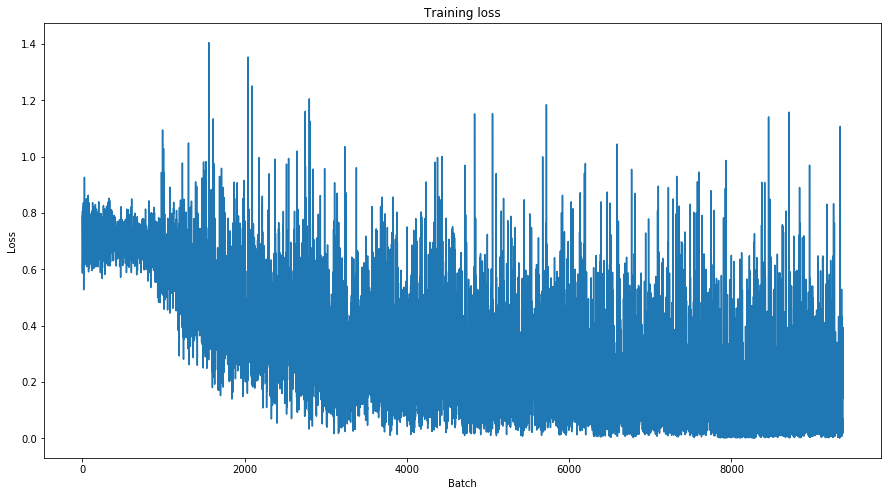

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [18]:
import os 

if "weights_name" not in params:
    params["weights_name"] = "pytorch_model.bin"
if "config_name" not in params:
    params["config_name"] = "config.json"

output_model_file = os.path.join(params["output_dir"], params["weights_name"])
output_config_file = os.path.join(params["output_dir"], params["config_name"])
print(f'Save model, config and vocab to {params["output_dir"]}..')
torch.save(model.state_dict(), output_model_file)
model.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(params["output_dir"])
print(f'Model, config and vocab are saved in {params["output_dir"]}..')

Save model, config and vocab to outputs/xlm_256/..
Model, config and vocab are saved in outputs/xlm_256/..


# Evaluation

In [19]:
from modules.model_functions import evaluate 

results = evaluate(model, eval_dataloader, params, prefix="")
results

INFO:modules.model_functions:***** Eval results  *****
INFO:modules.model_functions:  accuracy = 0.89876
INFO:modules.model_functions:  eval_loss = 0.33526211060697997
INFO:modules.model_functions:  f1-score = 0.8956933855347209
INFO:modules.model_functions:  fn = 1633
INFO:modules.model_functions:  fp = 898
INFO:modules.model_functions:  logloss = 3.312417588938419
INFO:modules.model_functions:  mcc = 0.7989022741563808
INFO:modules.model_functions:  model = xlm-mlm-ende-1024
INFO:modules.model_functions:  precision = 0.923671908202295
INFO:modules.model_functions:  recall = 0.86936
INFO:modules.model_functions:  task_name = binary
INFO:modules.model_functions:  tn = 11602
INFO:modules.model_functions:  tp = 10867


{'mcc': 0.7989022741563808,
 'accuracy': 0.89876,
 'precision': 0.923671908202295,
 'recall': 0.86936,
 'f1-score': 0.8956933855347209,
 'logloss': 3.312417588938419,
 'tp': 10867,
 'tn': 11602,
 'fp': 898,
 'fn': 1633,
 'task_name': 'binary',
 'model': 'xlm-mlm-ende-1024',
 'eval_loss': 0.33526211060697997}